A pipeline for preprocessing Valid Time Extent Code (VTEC) archives from the National Weather Service.
Dataset: https://mesonet.agron.iastate.edu/info/datasets/vtec.html

In [1]:
import math
from pathlib import Path
import os

import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import ruptures as rpt
import pandas as pd
import vaex as vx
import geopandas as gpd
import cuspatial as cs
import cudf
import cupy as cp
import cuml

color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')
# sns.crayon_palette(['Red', 'Blue'])
sns.set_palette("Set2")

# HOME = Path(os.environ['HOME'])
HOME = Path("/notebooks")
# HOME = Path("/mnt/c/Users/isabe")
# PROJECT = HOME / "Documents/repos/eagle-comp"
PROJECT = HOME / "eagle-comp"
DATA = PROJECT / "data"
EAGLE_DATA = Path("/datasets/eagle-comp")

In [ ]:
def add_zeroes(outage_df):
    outage_df = outage_df.reset_index()
    outage_df['run_start_time'] = pd.to_datetime(outage_df['run_start_time'])
    outage_df = outage_df.set_index(["fips_code", "run_start_time"]).sort_index()
    na_rows = outage_df[outage_df['sum'].isna()].index
    outage_df = outage_df.groupby('fips_code').apply(lambda g: g.loc[g.index.get_level_values(0)[0]].resample('15T').mean().fillna(0))
    outage_df.loc[na_rows] = np.nan
    outage_df.reset_index(inplace=True)
    return outage_df

### VTEC Lookup Table

In [ ]:
# https://github.com/akrherz/pyIEM/blob/main/src/pyiem/nws/vtec.py
VTEC_CLASS = { "O": "Operational", "T": "Test", "E": "Experimental", "X": "Experimental VTEC"}

VTEC_ACTION = {
    "NEW": "issues",
    "CON": "continues",
    "EXA": "expands area to include",
    "EXT": "extends time of",
    "EXB": "extends time and expands area to include",
    "EXP": "expires",
    "UPG": "issues upgrade to",
    "CAN": "cancels",
    "EXP": "expires",
    "ROU": "routine",
    "COR": "corrects",
}

VTEC_SIGNIFICANCE = {
    "W": "Warning",
    "Y": "Advisory",
    "A": "Watch",
    "S": "Statement",
    "O": "Outlook",
    "N": "Synopsis",
    "F": "Forecast",
}

# https://www.nws.noaa.gov/directives/sym/pd01017003curr.pdf
VTEC_PHENOMENA = {
    "AF": "Ashfall",
    "AS": "Air Stagnation",
    "BH": "Beach Hazard",
    "BS": "Blowing Snow",
    "BW": "Brisk Wind",
    "BZ": "Blizzard",
    "CF": "Coastal Flood",
    "CW": "Cold Weather",
    "DF": "Debris Flow",
    "DS": "Dust Storm",
    "DU": "Blowing Dust",
    "EC": "Extreme Cold",
    "EH": "Excessive Heat",
    "EW": "Extreme Wind",
    "FA": "Flood",
    "FF": "Flash Flood",
    "FG": "Dense Fog",
    "FL": "Flood",
    "FR": "Frost",
    "FW": "Red Flag",
    "FZ": "Freeze",
    "UP": "Freezing Spray",
    "GL": "Gale",
    "HF": "Hurricane Force Wind",
    "HI": "Inland Hurricane",
    "HS": "Heavy Snow",
    "HT": "Heat",
    "HU": "Hurricane",
    "HW": "High Wind",
    "HY": "Hydrologic",
    "HZ": "Hard Freeze",
    "IP": "Sleet",
    "IS": "Ice Storm",
    "LB": "Lake Effect Snow and Blowing Snow",
    "LE": "Lake Effect Snow",
    "LO": "Low Water",
    "LS": "Lakeshore Flood",
    "LW": "Lake Wind",
    "MA": "Marine",
    "MF": "Marine Dense Fog",
    "MH": "Marine Ashfall",
    "MS": "Marine Dense Smoke",
    "RB": "Small Craft for Rough",
    "RP": "Rip Currents",
    "SB": "Snow and Blowing",
    "SC": "Small Craft",
    "SE": "Hazardous Seas",
    "SI": "Small Craft for Winds",
    "SM": "Dense Smoke",
    "SN": "Snow",
    "SQ": "Snow Squall",
    "SR": "Storm",
    "SS": "Storm Surge",
    "SU": "High Surf",
    "SV": "Severe Thunderstorm",
    "SW": "Small Craft for Hazardous Seas",
    "TI": "Inland Tropical Storm",
    "TO": "Tornado",
    "TR": "Tropical Storm",
    "TS": "Tsunami",
    "TY": "Typhoon",
    "WC": "Wind Chill",
    "WI": "Wind",
    "WS": "Winter Storm",
    "WW": "Winter Weather",
    "ZF": "Freezing Fog",
    "ZR": "Freezing Rain",
}

HVTEC_RECORD = {
    "OO": "is not applicable",
    "NO": "is not expected",
    "NR": "may be expected",
    "UU": "is not available",
}

HVTEC_CAUSE = {
    "ER": "Excessive Rainfall",
    "SM": "Snowmelt",
    "RS": "Rain and Snowmelt",
    "DM": "Dam or Levee Failure",
    "GO": "Glacier-Dammed Lake Outburst",
    "IJ": "Ice Jam",
    "IC": "Rain and/or Snowmelt and/or Ice Jam",
    "FS": "Upstream Flooding plus Storm Surge",
    "FT": "Upstream Flooding plus Tidal Effects",
    "ET": "Elevated Upstream Flow plus Tidal Effects",
    "WT": "Wind and/or Tidal Effects",
    "DR": "Upstream Dam or Reservoir Release",
    "MC": "Other Multiple Causes",
    "OT": "Other Effects",
    "UU": "Unknown",
}

HVTEC_SEVERITY = {
    "N": "None",
    "0": "None",
    "1": "Minor",
    "2": "Moderate",
    "3": "Major",
    "U": "Unknown",
}

### NWS VTEC Archive Preprocessing

In [5]:
# weather = pd.read_csv(DATA / "weather/2022_all/wwa_202201010000_202212312359.csv")
weather_shape = gpd.read_file(DATA / "weather/2022/wwa_202201010000_202212312359.shp")
weather_shape = weather_shape[weather_shape['SIG'].isin(['W', 'Y', 'A'])]
weather_shape["INIT_ISS"] = pd.to_datetime(weather_shape["INIT_ISS"])
weather_shape["EXPIRED"] = pd.to_datetime(weather_shape["EXPIRED"])
weather_shape["UPDATED"] = pd.to_datetime(weather_shape["UPDATED"])
weather_shape["ISSUED"] = pd.to_datetime(weather_shape["ISSUED"])
weather_shape["ETN"] = weather_shape["ETN"].astype(int)
weather_shape["EMERGENC"] = weather_shape["EMERGENC"].astype(bool)
# weather_shape = weather_shape[~weather_shape["STATUS"].isin(["CAN", "EXP"])]

In [6]:
# Load Census tract boundaries and aggregate to county boundaries
tracts_2020 = (DATA / "tracts" / "2020").glob("*.shp")
tracts_2020 = [gpd.read_file(f) for f in tracts_2020]
tracts_2020 = pd.concat(tracts_2020, ignore_index=True)
tracts_2020.set_index("GEOID", inplace=True)
tracts_2020['county_fips'] = tracts_2020['STATEFP'] + tracts_2020['COUNTYFP']
tracts_2020['county_fips'] = tracts_2020['county_fips'].astype(int)
counties_2020 = tracts_2020[['county_fips', 'geometry']].dissolve(by='county_fips')
del tracts_2020
counties_2020 = counties_2020.copy()
counties_2020.sort_index(inplace=True)

In [ ]:
overlap_df = counties_2020.geometry.apply(lambda x: weather_shape.geometry.overlaps(x)).T

In [ ]:
overlap_df.to_csv(DATA / "weather_county_overlap.csv")

In [9]:
overlap_df = pd.read_csv(DATA / "weather_county_overlap.csv", index_col=0)
overlap_df.rename(columns=lambda x: int(x), inplace=True)

In [10]:
weather_shape = pd.merge(weather_shape, overlap_df, left_index=True, right_index=True)
weather_shape = weather_shape[weather_shape["SIG"].isin(["W", "Y"])].reset_index(drop=True).set_index(["WFO", "PHENOM", "ETN"]).sort_index()
weather_shape = weather_shape[weather_shape["STATUS"] != "CAN"]

In [ ]:
def get_weather_info(df):
    start_time = df["INIT_ISS"].min()
    end_time = df["EXPIRED"].max()
    latest_updated = df["UPDATED"].max()
    wfo, phenomena, etn = df.index[0]
    hv_cause, emergenc, latest_status = df[["HV_CAUSE", "EMERGENC", "STATUS"]].iloc[-1]
    fips = pd.DataFrame(df.iloc[:, 22:].any()).T#.any().where(lambda x: x == True).dropna().index.tolist()
    df = pd.DataFrame({
        "start_time": start_time,
        "end_time": end_time,
        "latest_updated": latest_updated, 
        "phenomena": phenomena,
        "hv_cause": hv_cause,
        "emergenc": emergenc,
        "latest_status": latest_status,
        "wfo": wfo,
        "etn": etn,
        }, index=[0])
    df = df.merge(fips, how='inner', left_index=True, right_index=True)
    df.reset_index(inplace=True, drop=True)
    return df
weather_info = weather_shape.groupby(["WFO", "PHENOM", "ETN"]).apply(get_weather_info)
weather_info.reset_index(inplace=True, drop=True)
# weather_info.to_csv(DATA / "weather_info.csv")

In [ ]:
weather_info = pd.read_csv(DATA / "weather_info.csv", index_col=0)
features = [
    "start_time",
    "end_time",
    "last_updated",
    "phenomena",
    "hv_cause",
    "emergenc",
    "latest_status",
    "wfo",
    "etn",
]
weather_info.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)

In [ ]:
weather_info['start_time'] = pd.to_datetime(weather_info['start_time'])
weather_info['end_time'] = pd.to_datetime(weather_info['end_time'])
weather_info['latest_updated'] = pd.to_datetime(weather_info['latest_updated'])
weather_info.set_index(["phenomena", "wfo", "etn"], inplace=True)
weather_info.index.is_unique

True

In [ ]:
df_2022 = pd.read_csv(EAGLE_DATA / f"eaglei_outages_2022.csv")
df_2022 = add_zeroes(df_2022[['fips_code', 'run_start_time', 'sum']])
df_2022.set_index(['fips_code', 'run_start_time'], inplace=True)
# Add VTEC phenom types as columns to data_2022
# df_2022[list(VTEC_PHENOMENA.keys())] = False

NameError: name 'add_zeroes' is not defined

In [ ]:
weather_info["fips"] = weather_info.apply(lambda x: x.iloc[6:].where(lambda x: x == True).dropna().index.tolist(), axis=1)

In [ ]:
county_weather = weather_info.loc[:, ["start_time", "end_time", "latest_updated", "hv_cause", "emergenc", "latest_status", "fips"]] \
                            .explode("fips") \
                            .dropna() \
                            .reset_index() \
                            .set_index(["fips", "phenomena", "wfo", "etn"]) \
                            .sort_index()
county_weather

start_time            end_time  \
fips  phenomena wfo etn                                           
1001  FA        BMX 1   2022-01-02 08:05:00 2022-02-05 15:15:00   
                    2   2022-01-09 22:53:00 2022-02-24 19:30:00   
                    3   2022-02-04 00:16:00 2022-03-16 18:30:00   
                    4   2022-02-04 02:51:00 2022-03-17 01:15:00   
                    5   2022-02-04 03:19:00 2022-03-23 15:00:00   
...                                     ...                 ...   
72127 FF        JSJ 92  2022-11-07 20:19:00 2022-11-07 23:30:00   
78010 FA        JSJ 83  2022-04-30 16:03:00 2022-04-30 18:00:00   
78020 FA        JSJ 30  2022-02-06 08:32:00 2022-10-27 11:00:00   
78030 FA        JSJ 30  2022-02-06 08:32:00 2022-10-27 11:00:00   
                    83  2022-04-30 16:03:00 2022-04-30 18:00:00   

                             latest_updated hv_cause  emergenc latest_status  
fips  phenomena wfo etn                                                       
1001  FA        BMX 1   2022-02-04 15:09:00       ER     False           NEW  
                    2   2022-02-23 19:24:00       ER     False           CON  
                    3   2022-03-16 12:31:00       ER     False           NEW  
                    4   2022-03-16 22:06:00       ER     False           NEW  
                    5   2022-03-23 12:13:00       ER     False           EXT  
...                                     ...      ...       ...           ...  
72127 FF        JSJ 92  2022-11-07 23:25:00       ER     False           EXP  
78010 FA        JSJ 83  2022-04-30 17:52:00       ER     False           EXP  
78020 FA        JSJ 30  2022-10-27 08:44:00       ER     False           EXT  
78030 FA        JSJ 30  2022-10-27 08:44:00       ER     False           EXT  
                    83  2022-04-30 17:52:00       ER     False           EXP  

[109572 rows x 6 columns]

In [ ]:
def melt_weather_event(df):
    df = df.reset_index() \
    .where(lambda df: df['latest_status'] != 'CAN').dropna() \
    .set_index(["phenomena", "wfo", "etn"]) \
    .melt(id_vars=["hv_cause", "emergenc", "latest_status", "latest_updated"], value_vars=["start_time", "end_time"], var_name="time_type", value_name="time", ignore_index=False) \
    .sort_index()
    return df
# la_events = weather_info[weather_info[6037]].reset_index() \
#     .where(lambda df: df['latest_status'] != 'CAN').dropna() \
#     .set_index(["phenomena", "wfo", "etn"]) \
#     .melt(id_vars=["hv_cause", "emergenc", "latest_status", "latest_updated"], value_vars=["start_time", "end_time"], var_name="time_type", value_name="time", ignore_index=False) \
#     .sort_index()
# la_events

In [ ]:
melted_weather = county_weather.groupby("fips").apply(melt_weather_event)

In [ ]:
def resample_melted_weather(df):
    df = df.groupby(["phenomena", "wfo", "etn"]) \
        .apply(lambda interval: interval.set_index("time").sort_index().resample("15T").bfill()) \
        .reset_index() \
        .sort_values(["phenomena", "time", "latest_updated"]) \
        .set_index(["phenomena", "time"])
    df = df.loc[~df.index.duplicated(keep='last')]
    return df
resampled_melted_weather = melted_weather.groupby("fips").apply(resample_melted_weather)

In [ ]:
resampled_melted_weather = resampled_melted_weather.set_index(["fips", "phenomena", "time"]).sort_index()

In [ ]:
df_2022.reset_index().rename(columns={"fips_code": "fips", "run_start_time": "time"}) \
    .set_index(["fips", "time"])

,,index,county,state,sum
fips,time,,,,
1005,2022-01-01 00:00:00,0,Barbour,Alabama,4.0
1009,2022-01-01 00:00:00,1,Blount,Alabama,160.0
1051,2022-01-01 00:00:00,2,Elmore,Alabama,3.0
1055,2022-01-01 00:00:00,3,Etowah,Alabama,4.0
1057,2022-01-01 00:00:00,4,Fayette,Alabama,4.0
...,...,...,...,...,...
72031,2022-11-12 18:30:00,22327828,Carolina,Puerto Rico,1869.0
72097,2022-11-12 18:30:00,22327829,Mayagüez,Puerto Rico,420.0
72113,2022-11-12 18:30:00,22327830,Ponce,Puerto Rico,214.0


In [ ]:
# rename columns in df_2022 to match columns in resampled_melted_weather
resampled_melted_weather_outages = df_2022.reset_index().rename(columns={"fips_code": "fips", "run_start_time": "time"}) \
    .set_index(["fips", "time"]) \
    .sort_index() \
    .merge(resampled_melted_weather, how='inner', left_index=True, right_index=True)

In [ ]:
resampled_melted_weather_outages.drop(columns=["index"], inplace=True)

In [ ]:
resampled_melted_weather_outages.to_csv(DATA / "resampled_melted_weather_outages.csv")

In [ ]:
impacted_timestamps = resampled_melted_weather_outages.reset_index().set_index(["fips", "time"]).sort_index().index.drop_duplicates()

In [ ]:
# drop impacted_timestamps in df_2022
unimpacted_outages = df_2022.reset_index().rename(columns={"fips_code": "fips", "run_start_time": "time"}) \
    .set_index(["fips", "time"]) \
    .sort_index() \
    .drop(index=impacted_timestamps) 

In [ ]:
unimpacted_outages.to_csv(DATA / "unimpacted_outages.csv")

In [ ]:
weather_events = pd.read_csv(DATA / "resampled_melted_weather_outages.csv")
unimpacted_outages = pd.read_csv(DATA / "unimpacted_outages.csv")

In [ ]:
weather_events = weather_events.set_index(["fips", "phenomena", "time"]).sort_index()
unimpacted_outages = unimpacted_outages.set_index(["fips", "time"]).sort_index().drop(columns=["index"])

In [ ]:
outages_duration_2022 = pd.read_csv('outages_duration_2022.csv', parse_dates=True)
outages_duration_2022['fips_code'] = outages_duration_2022['fips_code'].astype(int)
outages_duration_2022['run_start_time'] = pd.to_datetime(outages_duration_2022['run_start_time'])
outages_duration_2022.set_index(["fips_code", "run_start_time"], inplace=True)
outages_duration_2022.sort_index(inplace=True)

In [ ]:
outages_duration_2022.index = outages_duration_2022.index.rename(["fips", "time"])

In [ ]:
weather_events.reset_index(inplace=True)
weather_events['time'] = weather_events["time"].astype("datetime64[ns]")
weather_events = weather_events.set_index(["fips", "phenomena", "time"]).sort_index()

In [ ]:
unimpacted_outages.reset_index(inplace=True)
unimpacted_outages['time'] = pd.to_datetime(unimpacted_outages['time'])
unimpacted_outages.set_index(["fips", "time"], inplace=True)

In [ ]:
outages_duration_2022.reset_index(inplace=True)
outages_duration_2022['time'] = pd.to_datetime(outages_duration_2022['time'])
outages_duration_2022.set_index(['fips', 'time'], inplace=True)

In [ ]:
weather_events.drop(columns=["county", "state", "sum", "latest_status", "latest_updated"], inplace=True)
unimpacted_outages.drop(columns=["county", "state"], inplace=True)

In [ ]:
# use the index from sample_weather_events to get the durations and outage_ids of the events
weather_events_outage_durations = weather_events.reset_index().merge(outages_duration_2022[['sum', 'duration', 'outage_id']].reset_index(), on=["fips", "time"], how='inner')
unimpacted_outages_durations = unimpacted_outages.reset_index().merge(outages_duration_2022[['sum', 'duration', 'outage_id']].reset_index(), on=["fips", "time"], how='inner')

In [ ]:
weather_events_outage_durations.to_csv('weather_events_outage_durations_2022.csv')
unimpacted_outages_durations.to_csv('unimpacted_outages_durations_2022.csv')

In [ ]:
weather_events_outage_durations = pd.read_csv('weather_events_outage_durations_2022.csv', parse_dates=True, index_col=0)
unimpacted_outages_durations = pd.read_csv('unimpacted_outages_durations_2022.csv', parse_dates=True, index_col=0)

In [ ]:
weather_events_outage_durations.set_index(['fips', 'phenomena', 'time'], inplace=True)
unimpacted_outage_durations.reset_index(inplace=True)
unimpacted_outages_durations.set_index(['fips', 'time'], inplace=True)

In [ ]:
weather_events_outage_durations = weather_events_outage_durations.reset_index().set_index(['phenomena', 'fips', 'time']).sort_index()

In [ ]:
mean_weather_outage_durations = weather_events_outage_durations \
    .groupby(['phenomena', 'fips', 'outage_id'])['duration'].first() \
    .groupby(['phenomena', 'fips']).mean()

In [ ]:
mean_weather_outage_durations = weather_events_outage_durations \
    .groupby(['phenomena', 'fips', 'outage_id'])['duration'].first() \
    .groupby(['phenomena', 'fips']).mean()

In [ ]:
mean_weather_outage_durations.index.get_level_values("phenomena").unique()

Index(['FA', 'FF', 'FL'], dtype='object', name='phenomena')

In [ ]:
mean_categorized_outage_durations = mean_weather_outage_durations.unstack().T.merge(mean_unimpacted_outage_durations, left_index=True, right_index=True, how='outer')

In [ ]:
mean_categorized_outage_durations.rename(columns={'duration': 'unimpacted'}, inplace=True)

In [ ]:
df_2022 = pd.read_csv(EAGLE_DATA / "eaglei_outages_2022.csv", index_col=0)

In [ ]:
location_names = df_2022.groupby('fips_code')["county", "state"].first()

/tmp/ipykernel_32/2226066502.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  location_names = df_2022.groupby('fips_code')["county", "state"].first()


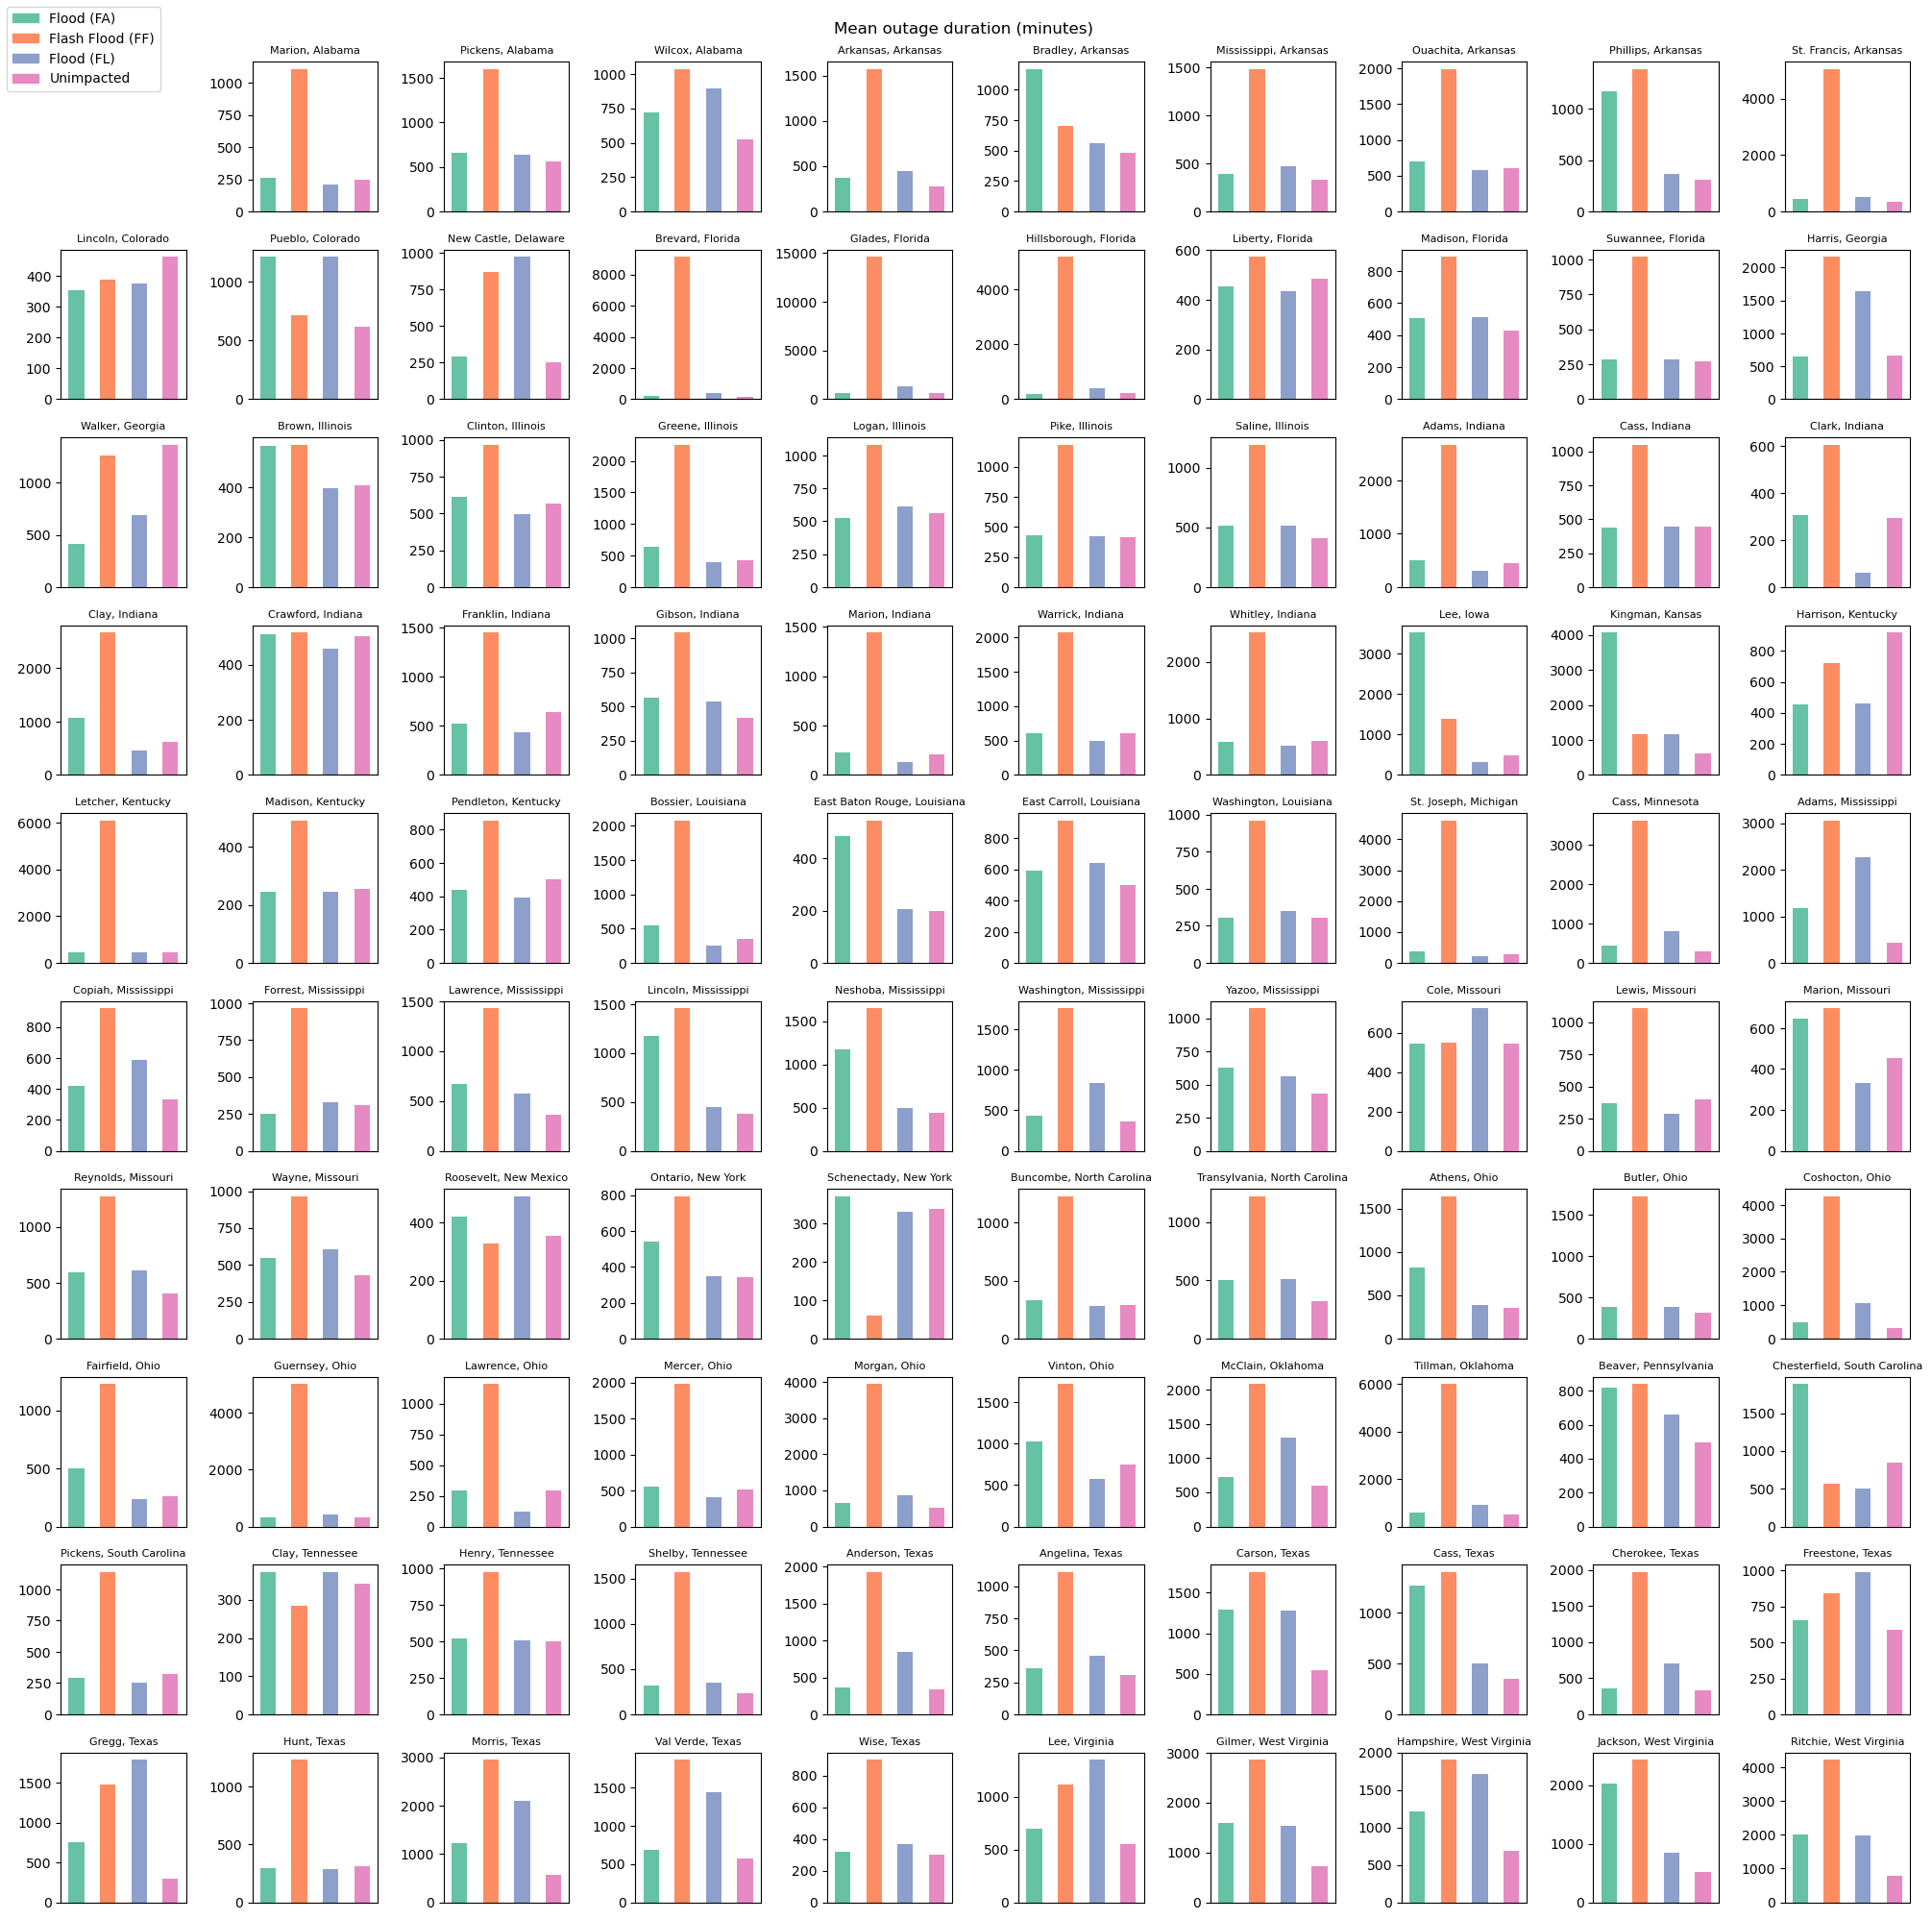

In [ ]:
# imporot mpatches
import matplotlib.patches as mpatches
# plot this in 10x10 subplots grid, where each suplot is a bar plot of the mean outages for each category
# make the bars different colors for each category
plotted = mean_categorized_outage_durations.dropna()
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, (fips_code, row) in enumerate(plotted.iterrows()):
    if i == 0:
        # make it invisible
        axes[i // 10, i % 10].axis('off')
        continue
    ax = axes[i // 10, i % 10]
    palette = sns.color_palette("Set2", len(row))
    row.plot(kind='bar', ax=ax, color=palette)
    # ax.set_ylim(0, 2000)
    # disable xticks
    ax.set_xticks([])
    # ax.set_xticklabels(row.index, rotation=45)
    ax.set_xlabel('')
    # ax.set_ylabel('Mean outage duration (minutes)')
    # set legend for entire plot only
    # if i == 0:
    #     ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # # set y axis label for entire plot only
    # if i == 5:
    #     ax.set_ylabel('Mean outage duration (minutes)')
    county, state = location_names.loc[fips_code]
    ax.set_title(f"{county}, {state}", fontsize=8)
# set legend for entire plot using color palette
categories = [f"{VTEC_PHENOMENA[key]} ({key})" for key in row.index[:-1]] + ["Unimpacted"]
handles = [mpatches.Patch(color=palette[i], label=category) for i, category in enumerate(row.index)]
labels = categories
fig.legend(handles, labels, loc='upper left')
# add suptitle that doesn't overlap
fig.suptitle('Mean outage duration (minutes)', y=0.99)
# vertical spacing
plt.tight_layout()

In [ ]:
fips_codes = outages_2022.index.get_level_values("fips_code").unique()
np.random.seed(42)
# randomly sample 10% of the fips codes
sample_fips = np.random.choice(fips_codes, size=int(len(fips_codes) * 0.1), replace=False)
# convert to dataframe with sample_fips as index called 'fips_code'
# sample_fips = pd.DataFrame(sample_fips, columns=["fips_code"]).set_index("fips_code")

In [ ]:
fips_sample_index = pd.DataFrame(index=sample_fips)

In [ ]:
mean_categorized_outage_durations = mean_categorized_outage_durations.merge(fips_sample_index, left_index=True, right_index=True, how='inner')

In [ ]:
plotted = mean_categorized_outage_durations.dropna()

In [ ]:
plotted.rename(columns={"duration": "Normal"}, inplace=True)

/tmp/ipykernel_32/3317839540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotted.rename(columns={"duration": "Normal"}, inplace=True)


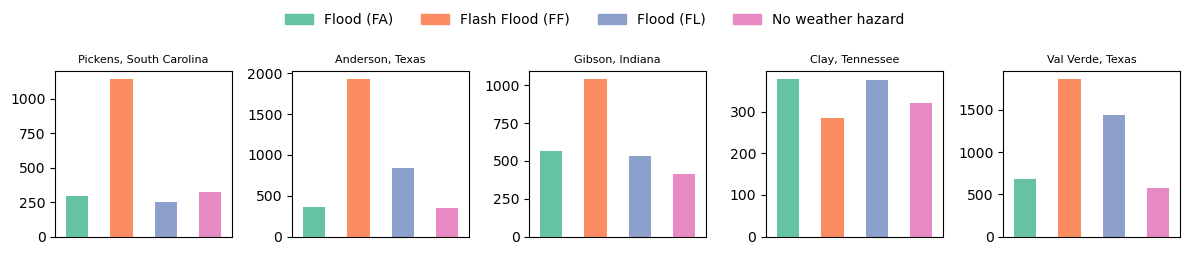

In [ ]:
import matplotlib.patches as mpatches
# select random 5 from plotted df
random_plots = plotted.sample(5, random_state=1)
fig, axes = plt.subplots(1, 5, figsize=(12, 2.5))

for i, (fips_code, row) in enumerate(random_plots.iterrows()):
    categories = [f"{VTEC_PHENOMENA[key]} ({key})" for key in row.index[:-1]] + ["No weather hazard"]
    ax = axes[i]
    palette = sns.color_palette("Set2", len(row))
    row.plot(kind='bar', ax=ax, color=palette)
    # ax.set_ylim(0, 2000)
    # disable xticks
    ax.set_xticks([])
    # ax.set_xticklabels(row.index, rotation=45)
    # ax.set_xticklabels(categories)
    # ax.set_xlabel('')
    # ax.set_ylabel('Mean outage duration (minutes)')
    # set legend for entire plot only
    # if i == 0:
    #     ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # # set y axis label for entire plot only
    # if i == 5:
    #     ax.set_ylabel('Mean outage duration (minutes)')
    county, state = location_names.loc[fips_code]
    ax.set_title(f"{county}, {state}", fontsize=8)
# axes[-1].set_visible(False)
# set legend for entire plot using color palette
handles = [mpatches.Patch(color=palette[i], label=category) for i, category in enumerate(row.index)]
labels = categories
fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False)
# add suptitle that doesn't overlap
fig.suptitle(' ', y=1.0)
# vertical spacing
plt.tight_layout()